# ACR Phantom Slice Profile Measurements

Based on positive plates.

## Analysis of Angled Plates

In [1]:
import numpy as np
import pandas as pd
from mriqa.dcmio import fetch_series
from mriqa.tools import show_mosaic
from mriqa.phantoms import phantom_mask_2d, find_phantom
from skimage.exposure import rescale_intensity
from scipy.ndimage.interpolation import zoom

from skimage.feature import match_template, register_translation

from mriqa.dcmio import (
    rx_coil_name, approx_slice_orientation,
    approx_phase_orientation, series_number, seq_name, protocol_name,
    pix_spacing_yx, number_of_frames
)

from mriqa.tools import rectangular_roi_coords

import matplotlib.pyplot as plt
import seaborn as sns

The slice profile objects are narrow (positive) plates. Quite a bit more fiddly than for the TO2 or PIQT.

Matrix (ZYX): [72, 512, 512]
Voxel Dimensions (ZYX): [2.0, 0.48828125, 0.48828125]


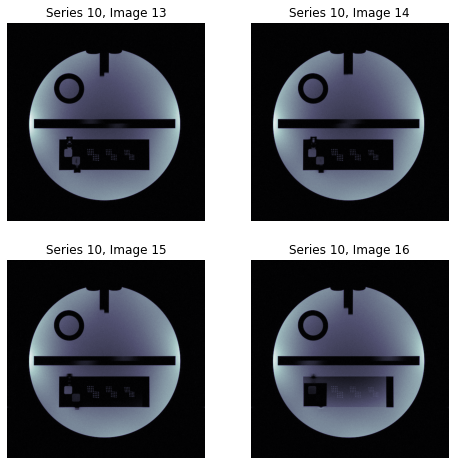

In [2]:
# ACR scan 2mm slice SE for orientation
patid = 'PQACRY20160411RHD'
stuid = '1'
sernos = [10]
dobjs = fetch_series(patid, stuid, sernos)

images = [d.pixel_array & 0x0fff for d in dobjs]
pix_dims = np.asarray(dobjs[0].PixelSpacing)
assert np.isclose(*pix_dims)

nslices =  len(dobjs)
slice_spacing = abs(np.diff(sorted(d.SliceLocation for d in dobjs)).mean())

print('Matrix (ZYX):', [len(images)] + list(images[0].shape))
print('Voxel Dimensions (ZYX):', [slice_spacing] + list(pix_dims))

show_mosaic(dobjs[12:16], cmap='bone')

We'll pick the single slice where the two plates most closely coincide.

Interpolation Factor: 2
New Matrix [1024, 1024]
New Voxel Dimensions [0.244140625, 0.244140625]
Image Min/Max 0 65535
Centre = (504, 527) , Radius = 391


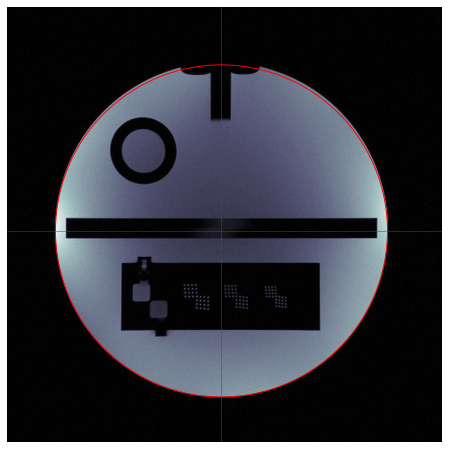

In [3]:
best_slice = 14
dobj = dobjs[best_slice-1]

pix_dims = pix_spacing_yx(dobj)
assert np.isclose(*pix_dims)

interpolation_factor = 2

image = rescale_intensity(zoom(dobj.pixel_array & 0x0fff, interpolation_factor))
pix_dims = tuple(d / interpolation_factor for d in pix_dims)

print('Interpolation Factor:', interpolation_factor)
print('New Matrix', list(image.shape))
print('New Voxel Dimensions', list(pix_dims))
print('Image Min/Max', image.min(), image.max())

ACRSP = {
    'Name': 'ACRSP',
    'Diameter': 190,  # mm
    'PD': 1.0,
    'T1': 500.0, # TODO: estimate from 10mM Ni2+ 
    'T2': 500.0,
    'Features': {
        'Plates': [
            ((-50, -7), (100, 4)),
            ((-50, -1), (100, 4))
        ],       
    },
    'FeatureAngles': {
        'Plates': 5.71 # from Phantom Guidance
    },
    'FeatureAxes': {
        'Plates': 1 # horizontal
    }
}

expected_radius = ACRSP['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)

print('Centre =', (centre_x, centre_y), ', Radius =', radius)

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='bone')
plt.axis('off')
plt.grid(False)
nrows, ncols = image.shape

plt.axvline(centre_x, linewidth=0.5, color='red')
plt.axhline(centre_y, linewidth=0.5, color='red')
plt.gcf().gca().add_artist(
    plt.Circle((centre_x, centre_y), radius, color='red', fill=False)
);

We need the phantom image to be quite carefully aligned as we have long thin regions of interest that would be pushed out of the plate if there is even as mall rotation. 

In [4]:
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks

def opt_angle_hough(image):
    # Normalize
    image = np.asarray(image, dtype='float')

    assert len(image.shape) == 2
    assert np.amax(image) != np.amin(image)

    image = (image - np.amin(image)) / (np.amax(image) - np.amin(image))
    edges = canny(image, sigma=2, low_threshold=0.1, high_threshold=0.5)
    _, angles = hough_line_peaks(*hough_line(edges))[:2]
    # expect 0 and 90 degrees; fix to all be about zero
    angles = [
        angle - np.pi/2 if angle > np.pi/4 else angle + np.pi/2 if angle < -np.pi/4 else angle
        for angle in angles
    ]
    return np.mean(angles)

print('α = %4.2f degrees' % np.degrees(opt_angle_hough(image)))

α = 0.00 degrees


In this case the phantom seems to be accurately aligned.

α = 0.00 degrees


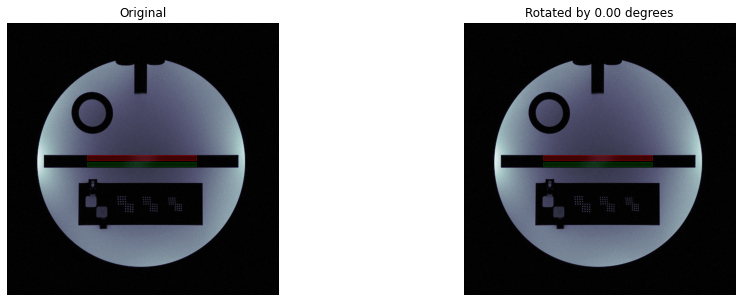

In [5]:
from skimage.feature import canny
from skimage.transform import (
    hough_line, hough_line_peaks,
    probabilistic_hough_line
)
from skimage.transform import rotate as skirotate

assert len(image.shape) == 2
assert np.amax(image) != np.amin(image)

angle = opt_angle_hough(image)
print('α = %4.2f degrees' % np.degrees(angle))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# NB don't seem to need to take the negative here
rotated_image = skirotate(image, 0.5*np.degrees(angle))

axs[0].imshow(image, cmap='bone')
axs[0].axis('off');

plates = ACRSP['Features']['Plates']
axis = ACRSP['FeatureAxes']['Plates']

x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=plates[0], centre=(centre_x, centre_y))
profile_1 = np.mean(image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)
axs[0].add_artist(plt.Rectangle([x, y], dx, dy, color='red', alpha=0.25))

x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=plates[1], centre=(centre_x, centre_y))
profile_2 = np.mean(image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)
axs[0].add_artist(plt.Rectangle([x, y], dx, dy, color='green', alpha=0.25))
axs[0].set_title('Original')
axs[1].imshow(rotated_image, cmap='bone')
axs[1].axis('off')
axs[1].set_title('Rotated by %0.2f degrees' % np.degrees(angle))

x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=plates[0], centre=(centre_x, centre_y))
profile_1 = np.mean(rotated_image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)
axs[1].add_artist(plt.Rectangle([x, y], dx, dy, color='red', alpha=0.25))

x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=plates[1], centre=(centre_x, centre_y))
profile_2 = np.mean(rotated_image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)
axs[1].add_artist(plt.Rectangle([x, y], dx, dy, color='green', alpha=0.25));

These regions really are very small and fiddly, really. I think we'll need to adjust the ROIs dynamically.
We'll trim the regions such that they are
 - confined to the 'black box' containing the plates
 - each only include only one of the two plates.

That way we can make them a bit more generous in the description on the understanding they may be adjusted later to fit better.

Firstly, we can find the 'black box':
- Assume roughly on centre line and confined to the phantom.
- Take min/max box from both plates feature (+ add margin in y, say the same again).
- Extract a sub region and project it horizontally to form a profile
- Use the zero crossings in the profile to get the margins of the box in y and construct new bounding box


We can then split this new ROI up vertically into the number plates we have leaving suitable margins between the sub-rois to avoid any chance of overlapping.


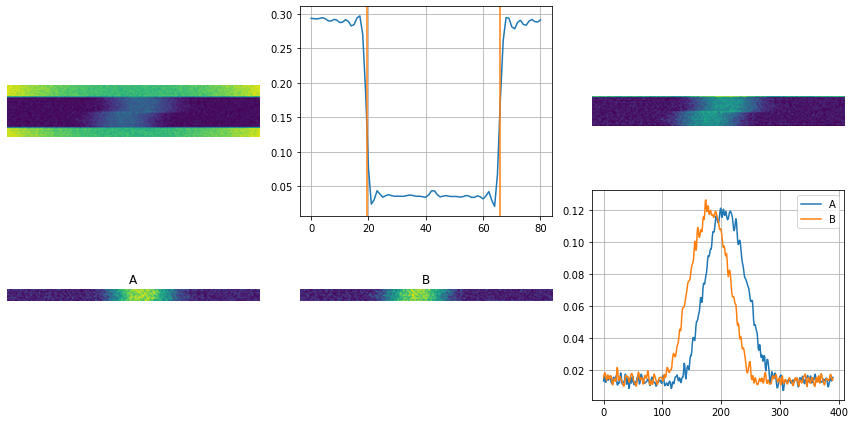

In [6]:
from scipy.interpolate import UnivariateSpline

expected_radius = ACRSP['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(rotated_image, expected_radius=expected_radius)

# region covering both plates
_, y1, _, dy1 = rectangular_roi_coords(pix_dims, rect=plates[0], centre=(centre_x, centre_y))
_, y2, _, dy2 = rectangular_roi_coords(pix_dims, rect=plates[1], centre=(centre_x, centre_y))

y0 = min(y1, y2)
yn = max(y1+dy1, y2+dy2)
dy = yn - y0

# increase size of region
y0 -= dy // 2
yn += dy // 2

# width is half phantom
x0 = centre_x - radius // 2
dx = radius
xn = x0 + dx

# extract region from image and generate vertical profile
roi = rotated_image[y0:yn, x0:xn]
profile = roi.mean(axis=1)

# find edges of region in y and reduce to integer indices
spline = UnivariateSpline(list(range(len(profile))), profile-np.max(profile)/2, s=0)
r1, r2 = spline.roots()
new_y0, new_dy = int(round(r1)) + y0, int(round(r2 - r1))
new_yn = new_y0 + new_dy

# adjust to avoid edges etc
margin = 2
y0_a = new_y0 + margin
dy_a = new_dy // 2 - 2 * margin
yn_a = y0_a + dy_a
y0_b = new_y0 + new_dy // 2 + margin
dy_b = new_dy // 2 - 2 * margin
yn_b = y0_b + dy_b

revised_roi = rotated_image[new_y0:new_yn, x0:xn]
sub_roi_a = rotated_image[y0_a:yn_a, x0:xn]
sub_roi_b = rotated_image[y0_b:yn_b, x0:xn]

profile_a = sub_roi_a.mean(axis=0)
profile_b = sub_roi_b.mean(axis=0)

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.ravel()

axs[0].imshow(roi)
axs[0].axis('off')
axs[1].plot(profile)
axs[1].grid(True)
axs[1].axvline(r1, color='C1')
axs[1].axvline(r2, color='C1')

axs[2].imshow(revised_roi)
axs[2].axis('off')

axs[3].imshow(sub_roi_a)
axs[3].axis('off')
axs[3].set_title('A')

axs[4].imshow(sub_roi_b)
axs[4].axis('off')
axs[4].set_title('B')

axs[5].plot(profile_a, label='A')
axs[5].plot(profile_b, label='B')
axs[5].grid(True)
axs[5].legend()

fig.tight_layout();

Bundle this up into a function to tweak the plates rois in the phantom description. We'll also need the reverse transform from image ROI to phantom description in mm.

In [7]:
def get_phantom_roi_coords(pix_dims, rect, centre):
    """
    Get phantom coordinates of a rectangle image ROI.

    The rectangle is specified as (x, y, dx, dy) in pixels.
    The ROI is shifted according to the specified phantom centre (NB in pixels). The returned
    specification (x, y), (dx, dy) is in mm.
    """
    x, y, dx, dy = rect
    centre_x, centre_y = centre
    pix_y, pix_x = pix_dims
    x = (x - centre_x) * pix_x
    y = (y - centre_y) * pix_y
    dx = dx * pix_x
    dy = dy * pix_y
    return (x, y), (dx, dy)

plate_both = get_phantom_roi_coords(pix_dims, (x0-20, new_y0, dx+40, new_dy), (centre_x, centre_y))
plate_a = get_phantom_roi_coords(pix_dims, (x0, y0_a, dx, dy_a), (centre_x, centre_y))
plate_b = get_phantom_roi_coords(pix_dims, (x0, y0_b, dx, dy_b), (centre_x, centre_y))

print(x0, new_y0, dx, new_dy)
print(x0, y0_a, dx, dy_a)
print(x0, y0_b, dx, dy_b)

def refine_regions(image, plates, pix_dims, centre):
    
    # plates in image space
    rois = [rectangular_roi_coords(pix_dims, rect=plate, centre=centre) for plate in plates]
    
    y0 = min(y for _, y, _, _  in rois)
    yn = max(y + dy for _, y, _, dy  in rois)
    dy = yn - y0

    x0 = min(x for x, _, _, _  in rois)
    xn = max(x + dx for x, _, dx, _  in rois)
    dx = xn - x0

    # increase size of region in y
    y0 -= dy // 2
    yn += dy // 2
    dy = yn - y0

    # extract region from image and generate vertical profile
    profile = image[y0:yn, x0:xn].mean(axis=1)

    # find edges of region in y and reduce to integer indices
    profile -= (np.max(profile) - np.min(profile)) / 2
    r1, r2 = UnivariateSpline(np.arange(len(profile)), profile, s=0).roots()
    new_y0, new_yn = y0 + int(round(r1)), y0 + int(round(r2))

    # adjust to avoid edges etc
    margin = 2    
    new_y0 += margin
    new_yn -= margin
    new_dy = new_yn - new_y0

    # split up into n sub regions
    nplates = len(plates)
    rois = [
        (x0, new_y0 + i * new_dy // nplates, dx, new_dy // nplates) for i in range(nplates)
    ]
        
    # transform back to phantom space
    plates = [
        get_phantom_roi_coords(pix_dims, roi, centre) for roi in rois
    ]

    return plates

309 497 391 46
309 499 391 19
309 522 391 19


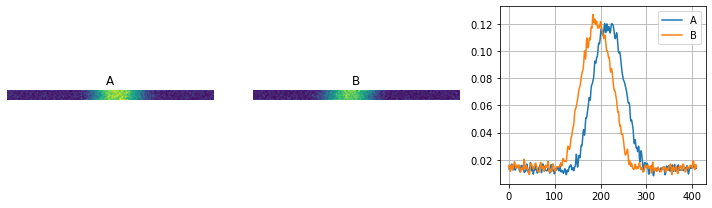

In [8]:
expected_radius = ACRSP['Diameter'] / 2 / pix_dims[0]

centre_x, centre_y, radius = find_phantom(rotated_image, expected_radius=expected_radius)

new_plates = refine_regions(
    rotated_image, plates=ACRSP['Features']['Plates'],
    pix_dims=pix_dims, centre=(centre_x, centre_y)
)

x1, y1, dx1, dy1 = rectangular_roi_coords(pix_dims, rect=new_plates[0], centre=(centre_x, centre_y))
x2, y2, dx2, dy2 = rectangular_roi_coords(pix_dims, rect=new_plates[1], centre=(centre_x, centre_y))

sub_roi_a = rotated_image[y1:y1+dy1, x1:x1+dx1]
sub_roi_b = rotated_image[y2:y2+dy2, x2:x2+dx2]

profile_a = sub_roi_a.mean(axis=0)
profile_b = sub_roi_b.mean(axis=0)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs = axs.ravel()

axs[0].imshow(sub_roi_a)
axs[0].axis('off')
axs[0].set_title('A')

axs[1].imshow(sub_roi_b)
axs[1].axis('off')
axs[1].set_title('B')

axs[2].plot(profile_a, label='A')
axs[2].plot(profile_b, label='B')
axs[2].grid(True)
axs[2].legend()

fig.tight_layout();

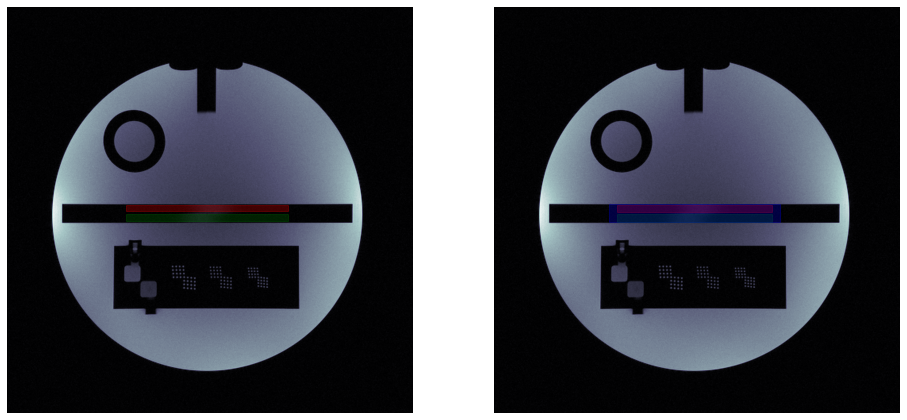

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(rotated_image, cmap='bone')
ax[0].axis('off')

plates = ACRSP['Features']['Plates']
axis = ACRSP['FeatureAxes']['Plates']

x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=plates[0], centre=(centre_x, centre_y))
profile_1 = np.mean(rotated_image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)
ax[0].add_artist(plt.Rectangle([x, y], dx, dy, color='red', alpha=0.25))

x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=plates[1], centre=(centre_x, centre_y))
profile_2 = np.mean(rotated_image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)
ax[0].add_artist(plt.Rectangle([x, y], dx, dy, color='green', alpha=0.25))

ax[1].imshow(rotated_image, cmap='bone')
ax[1].axis('off')

x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=plate_a, centre=(centre_x, centre_y))
ax[1].add_artist(plt.Rectangle([x, y], dx, dy, color='red', alpha=0.25))

x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=plate_b, centre=(centre_x, centre_y))
ax[1].add_artist(plt.Rectangle([x, y], dx, dy, color='green', alpha=0.25))

x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=plate_both, centre=(centre_x, centre_y))
ax[1].add_artist(plt.Rectangle([x, y], dx, dy, color='blue', alpha=0.25));

OK, with these we can tweak the slice_profile report.

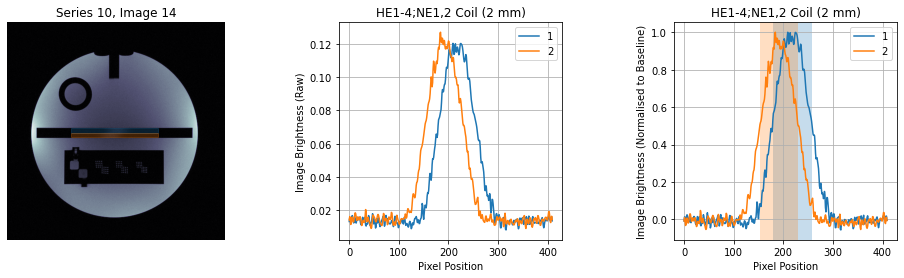

Plate Angle  =  5.7 degrees
FWHM     (1) =  79.7 pixels, or 1.9 mm
FWHM     (2) =  78.0 pixels, or 1.9 mm
FWHM (GMEAN) =  78.9 pixels, or 1.9 mm


FWHM1Pixels   FWHM1MM  FWHM2Pixels   FWHM2MM  FWHMGMeanPixels  \
SliceThickness                                                                  
2.0               79.710589  1.945856    78.003269  1.904178        78.852308   

                FWHMGMeanMM  
SliceThickness               
2.0                1.924904

In [10]:
from mriqa.phantoms import TO2
from mriqa.dcmio import (
    number_of_frames, t_r, t_e, seq_name, rx_coil_name, protocol_name, slice_thickness,
    phase_enc_dirn, approx_phase_orientation, approx_slice_orientation, recon_scale_factor,
    pix_spacing_yx, matrix_yx, readout_bandwidth, readout_sensitivity, series_number,
    number_of_averages, number_of_phase_encoding_steps
)

from scipy.ndimage.interpolation import zoom as ndizoom
from scipy.interpolate import UnivariateSpline
from scipy.stats.mstats import gmean

def slice_profile_report(dobj, frame=None, flipped_ud=False, flipped_rl=False, rotate=False, adjust=False, phantom=TO2, plate_angle=None, axis=None):
    """
    Report on slice profile measurement.

    Takes a DICOM object which is a single slice of phantom where the plate
    profiles are reasonably central.

    Plots the image with the profile positions marked on, the raw profile and a
    normalised profile accounting for a multiplicative bias field.

    The FWHM is reported in mm for each profile individually and for their
    geometric mean.

    """

    def contrast_is_negative(x):
        nx = len(x)
        middle = x[nx//4:3*nx//4].mean()
        ends = np.hstack([x[:nx//4], x[-nx//4:]]).mean()
        return middle < ends


    def half_height_crossings(x):
        # Create a spline of the profile shifted to move its half-height to zero
        x = np.asarray(x)
        assert x.ndim == 1

        # find the zero crossings (no smoothing)
        half_height = x.max() / 2
        roots = UnivariateSpline(np.arange(len(x)), x - half_height, s=0).roots()

        # handle multiple adjacent roots due to noise
        if len(roots) > 2:
            # assume sorted
            splits = np.array([
                (roots[:i].mean(), roots[i:].mean()) for i in range(1, len(roots))
            ])
            split = np.argmax(splits[:, 1] - splits[:, 0])
            r1, r2 = splits[
                np.argmax(splits[:, 1] - splits[:, 0])
            ]
        else:
            r1, r2 = roots
        return r1, r2


    # Get single slice image data, handle multiframes
    if number_of_frames(dobj) > 1:
        if frame is None:
            frame = number_of_frames(dobj) // 2
        image = dobj.pixel_array[frame] & 0xfff
    else:
        image = dobj.pixel_array & 0xfff

    pixel_spacing = pix_spacing_yx(dobj)
    slice_thick = slice_thickness(dobj)
    coil_name = rx_coil_name(dobj)

    if flipped_ud:
        image = np.flipud(image)
    if flipped_rl:
        image = np.fliplr(image)

    if plate_angle is None:
        plate_angle = phantom['FeatureAngles']['Plates']
    # In degrees, normally 11.7 for TO2, about 6 degrees for ACR
    assert 0 < plate_angle < 45

    if axis is None:
        axis = phantom['FeatureAxes']['Plates']
    assert axis in (0, 1)

    # Interpolate up for analysis, NB change of pixel size
    interpolation_factor = 2
    image = rescale_intensity(ndizoom(image, interpolation_factor))
    pix_dims = np.asarray(pixel_spacing) / interpolation_factor
    
    # Assume square pixels
    assert np.allclose(pix_dims[0], pix_dims[1])

    # Centre phantom
    expected_radius = phantom['Diameter'] / 2 / pix_dims[0]
    centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)
    centre = centre_x, centre_y

    # Adjust phantom rotation to align to vertical and horizontal edges
    if rotate:
        opt_angle = opt_angle_hough(image)
        image = skirotate(image, np.degrees(opt_angle), center=(centre_y, centre_x))

    # Expected positions of plates
    plates = phantom['Features']['Plates']
    if adjust:
        plates = refine_regions(image, plates, pix_dims, centre)

    # Plotting area
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    fig.subplots_adjust(wspace=0.5)

    # Phantom image
    axes[0].imshow(image, cmap='bone')
    axes[0].axis('off')
    axes[0].axis('image')

    # Thick profile through first inclined plate
    x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=plates[0], centre=centre)
    profile_1 = np.mean(image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)

    # Show profiles on phantom
    axes[0].add_artist(plt.Rectangle([x, y], dx, dy, color='C0', alpha=0.25))

    # Thick profile through second inclined plate
    x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=plates[1], centre=centre)
    profile_2 = np.mean(image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)

    # Show on phantom
    axes[0].add_artist(plt.Rectangle([x, y], dx, dy, color='C1', alpha=0.25))

    axes[0].set_title(r'Series %d, Image %d' % (series_number(dobj), dobj.InstanceNumber))

    # Plot raw profiles
    axes[1].plot(profile_1, label='1')
    axes[1].plot(profile_2, label='2')
    axes[1].set_xlabel('Pixel Position')
    axes[1].set_ylabel('Image Brightness (Raw)')
    axes[1].set_title('%s Coil (%1.0f mm)' % (coil_name, slice_thick))
    axes[1].legend()
    axes[1].grid(True)

    x = list(range(20)) + list(range(len(profile_1)-20, len(profile_1)))
    if contrast_is_negative(profile_1):
        # Invert profiles and normalise to quadratic baseline fitted to the ends of the profile
        baseline_1 = np.poly1d(np.polyfit(x, profile_1[x], 2))(np.arange(len(profile_1)))
        profile_1 /= baseline_1
        profile_1 = 1 - profile_1
    else:
        profile_1 -= profile_1[x].mean()
        profile_1 /= profile_1.max()
        
    x = list(range(20)) + list(range(len(profile_2)-20, len(profile_2)))
    if contrast_is_negative(profile_2):
        baseline_2 = np.poly1d(np.polyfit(x, profile_2[x], 2))(np.arange(len(profile_2)))
        profile_2 /= baseline_2
        profile_2 = 1 - profile_2
    else:
        profile_2 -= profile_2[x].mean()
        profile_2 /= profile_2.max()

    # Plot the normalised profile
    axes[2].plot(profile_1, label='1')
    axes[2].plot(profile_2, label='2')
    axes[2].set_xlabel('Pixel Position')
    axes[2].set_ylabel('Image Brightness (Normalised to Baseline)')
    axes[2].set_title('%s Coil (%1.0f mm)' % (coil_name, slice_thick))
    axes[2].legend()
    axes[2].grid(True)


    r1, r2 = half_height_crossings(profile_1)
    fwhm_1_pixels = r2 - r1
    axes[2].axvspan(r1, r2, facecolor='C0', alpha=0.25)

    r1, r2 = half_height_crossings(profile_2)
    fwhm_2_pixels = r2 - r1
    axes[2].axvspan(r1, r2, facecolor='C1', alpha=0.25)

    plt.show()

    # Calculate FWHM in mm taking account of pixel rescaling and plate projection angle
    xspacing, yspacing = pix_dims

    fwhm_gm_pixels = gmean([fwhm_1_pixels, fwhm_2_pixels])

    fwhm_1_mm = fwhm_1_pixels * yspacing * np.tan(np.radians(plate_angle))
    fwhm_2_mm = fwhm_2_pixels * yspacing * np.tan(np.radians(plate_angle))

    fwhm_gm_mm = gmean([fwhm_1_mm, fwhm_2_mm])

    print('Plate Angle  = ', '%0.1f degrees' % plate_angle)
    print('FWHM     (1) = ', round(fwhm_1_pixels, 1),  'pixels, or', round(fwhm_1_mm, 1),  'mm')
    print('FWHM     (2) = ', round(fwhm_2_pixels, 1),  'pixels, or', round(fwhm_2_mm, 1),  'mm')
    print('FWHM (GMEAN) = ', round(fwhm_gm_pixels, 1), 'pixels, or', round(fwhm_gm_mm, 1), 'mm')

    return pd.DataFrame(
        [(slice_thick, fwhm_1_pixels, fwhm_1_mm, fwhm_2_pixels, fwhm_2_mm, fwhm_gm_pixels, fwhm_gm_mm)],
        columns=['SliceThickness', 'FWHM1Pixels', 'FWHM1MM', 'FWHM2Pixels', 'FWHM2MM', 'FWHMGMeanPixels', 'FWHMGMeanMM']
    ).set_index('SliceThickness')

slice_profile_report(dobj, rotate=True, adjust=True, phantom=ACRSP)

This looks reasonable now, but we need to check the plate angle. It looks to be about 6 degrees - half the angle for TO2 and the Philips PIQT.